In [32]:
# Making necessary imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import random
import gc
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import timm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfr = pd.DataFrame

In [3]:
# Fixing randomization seed for reproduceability 
def fix_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
fix_seed(42)

In [5]:
# Class ID to Labels Dictionary
labels = {
    0: "no",
    1: "sphere",
    2: "vort"
}

In [6]:
# Defining path variables for training and validation dataset
train_path = "/home/shreshthsharma/ssl/dataset/train"
valid_path = "/home/shreshthsharma/ssl/dataset/val"

In [7]:
sorted(os.listdir(train_path))

['.DS_Store', 'no', 'sphere', 'vort']

In [8]:
sorted(os.listdir(valid_path))

['.DS_Store', 'no', 'sphere', 'vort']

In [9]:
# Checking class distribution in the training dataset
for fol in sorted(os.listdir(train_path))[1:]:
    print(fol, ":", len(os.listdir(train_path+"/"+fol)))

no : 10000
sphere : 10000
vort : 10000


In [10]:
# Checking class distribution in validation dataset
for fol in sorted(os.listdir(valid_path))[1:]:
    print(fol, ":", len(os.listdir(valid_path+"/"+fol)))

no : 2500
sphere : 2500
vort : 2500


In [12]:
# Defining the Dataset Class
class Data(Dataset):
    def __init__(self, split):
        self.split = split
        
        if self.split=="train":
            self.path = train_path
        elif self.split=="valid":
            self.path = valid_path
        else:
            print("Check Split Arguement")

        self.num = []
        for fol in sorted(os.listdir(self.path))[1:]:
            self.num.append(len(os.listdir(self.path+"/"+fol)))

    def __len__(self):
        return sum(self.num)
    
    def __getitem__(self, index):
        if index < self.num[0]:
            arr = np.load(file=self.path+"/no/"+str(index+1)+".npy")
            lbl = 0
        elif index >= self.num[0] and index< self.num[0] + self.num[1]:
            arr = np.load(file=self.path+"/sphere/"+str(index+1-self.num[0])+".npy")
            lbl = 1
        else:
            arr = np.load(file=self.path+"/vort/"+str(index+1-self.num[0]-self.num[1])+".npy")
            lbl = 2
        
        arr = torch.tensor(arr, dtype=torch.float32)
        arr = nn.functional.interpolate(arr.unsqueeze(0), size=(224, 224))
        arr = arr.squeeze(0)
        lbl = torch.tensor(lbl)
        
        return {'X': arr, 'y': lbl}

In [13]:
# Creating training and validation dataset objects 
train_data = Data(split="train")
valid_data = Data(split="valid")

In [14]:
# Confirming length of datasets
print(len(train_data), len(valid_data))

30000 7500


In [15]:
# Sanity Check
valid_data[7499]

{'X': tensor([[[0.0045, 0.0045, 0.0135,  ..., 0.0079, 0.0079, 0.0034],
          [0.0045, 0.0045, 0.0135,  ..., 0.0079, 0.0079, 0.0034],
          [0.0135, 0.0135, 0.0056,  ..., 0.0146, 0.0180, 0.0135],
          ...,
          [0.0169, 0.0169, 0.0113,  ..., 0.0124, 0.0135, 0.0079],
          [0.0034, 0.0034, 0.0079,  ..., 0.0101, 0.0113, 0.0113],
          [0.0146, 0.0146, 0.0101,  ..., 0.0068, 0.0079, 0.0169]]]),
 'y': tensor(2)}

In [16]:
# Definining dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

In [17]:
# Importing the model from timm
model = timm.create_model('resnext50_32x4d.tv_in1k', pretrained=True, in_chans=1, num_classes=len(labels))

In [18]:
# Checking the device for training and inference
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
# Clear CUDA cache
torch.cuda.empty_cache()

# Perform garbage collection
gc.collect()

164

In [21]:
# Training configuration
model.to(device)
epochs = 17
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.01, min_lr=1e-6)
best_epoch = 0
stop_thresh = 4
best_val_loss = 1e+9

In [22]:
# Training Loop
# Skip this cell if you want to perform inference only
for epoch in tqdm(range(epochs)):
    train_loss = 0
    val_loss = 0
    model.train()
    for batch in tqdm(train_loader):
        for k,v in batch.items():
            batch[k] = v.to(device)
        optimizer.zero_grad()
        logits = model(batch['X'])
        loss = loss_fn(logits, batch['y'])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(train_loss)
    
    model.eval()
    for batch in tqdm(valid_loader):
        for k,v in batch.items():
            batch[k] = v.to(device)
        with torch.no_grad():
            logits = model(batch['X'])
            loss = loss_fn(logits, batch['y'])
            val_loss += loss.item()
    val_loss /= len(valid_loader)
    print(val_loss)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        print(f"Save model at {best_epoch}")
        torch.save(model.state_dict(),"task1_models/best.pth")
    
    # Early stopping

    if epoch - best_epoch > stop_thresh:
        print("Early Stopping!")
        break

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

1.0627220558332229


  0%|          | 0/235 [00:00<?, ?it/s]

0.8899115100820014
Save model at 0


  0%|          | 0/938 [00:00<?, ?it/s]

0.5992320010275729


  0%|          | 0/235 [00:00<?, ?it/s]

0.3853046143942691
Save model at 1


  0%|          | 0/938 [00:00<?, ?it/s]

0.3871157576264476


  0%|          | 0/235 [00:00<?, ?it/s]

0.32411566941027947
Save model at 2


  0%|          | 0/938 [00:00<?, ?it/s]

0.3108011140807796


  0%|          | 0/235 [00:00<?, ?it/s]

0.32168788133942067
Save model at 3


  0%|          | 0/938 [00:00<?, ?it/s]

0.2770082748361996


  0%|          | 0/235 [00:00<?, ?it/s]

0.3140964570831745
Save model at 4


  0%|          | 0/938 [00:00<?, ?it/s]

0.24927893611016685


  0%|          | 0/235 [00:00<?, ?it/s]

0.2842806297413846
Save model at 5


  0%|          | 0/938 [00:00<?, ?it/s]

0.22956438574479268


  0%|          | 0/235 [00:00<?, ?it/s]

0.2800285269684614
Save model at 6


  0%|          | 0/938 [00:00<?, ?it/s]

0.20995405492887123


  0%|          | 0/235 [00:00<?, ?it/s]

0.2399938418430851
Save model at 7


  0%|          | 0/938 [00:00<?, ?it/s]

0.19207436905335834


  0%|          | 0/235 [00:00<?, ?it/s]

0.2219527303538424
Save model at 8


  0%|          | 0/938 [00:00<?, ?it/s]

0.18139978768184845


  0%|          | 0/235 [00:00<?, ?it/s]

0.22353588696172896


  0%|          | 0/938 [00:00<?, ?it/s]

0.16977463375483112


  0%|          | 0/235 [00:00<?, ?it/s]

0.23038583364575468


  0%|          | 0/938 [00:00<?, ?it/s]

0.15612755193889363


  0%|          | 0/235 [00:00<?, ?it/s]

0.2830022840186002


  0%|          | 0/938 [00:00<?, ?it/s]

0.0768184450336857


  0%|          | 0/235 [00:00<?, ?it/s]

0.17076350793718023
Save model at 12


  0%|          | 0/938 [00:00<?, ?it/s]

0.05032624254017564


  0%|          | 0/235 [00:00<?, ?it/s]

0.18347114300048176


  0%|          | 0/938 [00:00<?, ?it/s]

0.03401035413276707


  0%|          | 0/235 [00:00<?, ?it/s]

0.2154835346011207


  0%|          | 0/938 [00:00<?, ?it/s]

In [22]:
# Loading the best model for combined predictions on the validation dataset
model.load_state_dict(torch.load("task1_models/best.pth"))
model.to(device)
preds = []
model.eval()
for batch in tqdm(valid_loader):
    for k,v in batch.items():
        batch[k] = v.to(device)
    with torch.no_grad():
        logits = model(batch['X'])
    pred = logits.cpu()
    for probs in pred:
        preds.append(probs)    

  0%|          | 0/235 [00:00<?, ?it/s]

In [23]:
# Defining softmax function for numpy arrays
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [24]:
# Creating the arrays for predictions, and true labels for validation set
preds_arr = softmax(np.array(preds))
true_arr = np.array([0]*2500 + [1]*2500 + [2]*2500)

In [25]:
# Creating csv for reference
dfr(preds_arr).to_csv('preds_ct.csv', index=False)

In [28]:
# Calculating ROC-AUC Score for all classes with One v/s All approach
metric1 = roc_auc_score(true_arr, preds_arr, multi_class='ovr', average=None)
print(metric1)
dfr(metric1).to_csv('roc_auc_results_task1.csv',index=False)

[0.99216548 0.9844204  0.99475568]


In [29]:
# Calculating Macro ROC-AUC Score with One v/s All approach
metric2 = roc_auc_score(true_arr, preds_arr, multi_class='ovr', average='macro')
metric2

0.9904471866666666

In [33]:
# Creating one hot encoding for labels for plotting ROC Curve
ohe_true = label_binarize(true_arr, classes=np.unique(true_arr))

In [34]:
# Storing FPR, TPR, and ROC-AUC for each class separately through One v/s All Approach for plotting ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ohe_true[:, i], preds_arr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

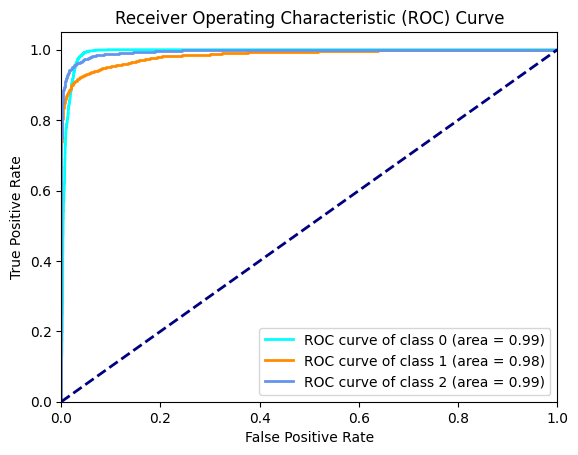

In [36]:
# Plot ROC curve
plt.figure()
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(np.unique(true_arr))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()